Predict the closing stock price of NASDAQ: NVDA for trading days from 24 October - 4 November (inclusive). There will be no restrictions on the data sources used (e.g. you may use relevant macro-economic indicators). Predictions will be compared with actual (after 4 November, but you have to submit before 23 October) using RMSE.


I chose to use LSTMs for this particular tasks as LSTMs are well suited for classifying, processing and making predictions based on time series data due to its capability of storing past information

**Importing Data**

In [4]:
import pandas as pd
stock_data = pd.read_csv('./NVDA_2Year.csv', index_col = 'Date')
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502 entries, 2020-10-19 to 2022-10-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       502 non-null    float64
 1   High       502 non-null    float64
 2   Low        502 non-null    float64
 3   Close      502 non-null    float64
 4   Adj Close  502 non-null    float64
 5   Volume     502 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.5+ KB


In [5]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-19,139.029999,139.835007,134.067505,134.977493,134.728363,29806800
2020-10-20,135.835007,137.997498,135.070007,136.455002,136.203186,22921200
2020-10-21,136.250000,137.914993,134.774994,135.247498,134.997894,21959600
2020-10-22,135.225006,136.117493,132.317505,133.610001,133.363403,29048000
2020-10-23,134.500000,135.932495,132.912506,135.902496,135.651672,23348400


**Importing Libraries**

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

**Basic Data Visualization**

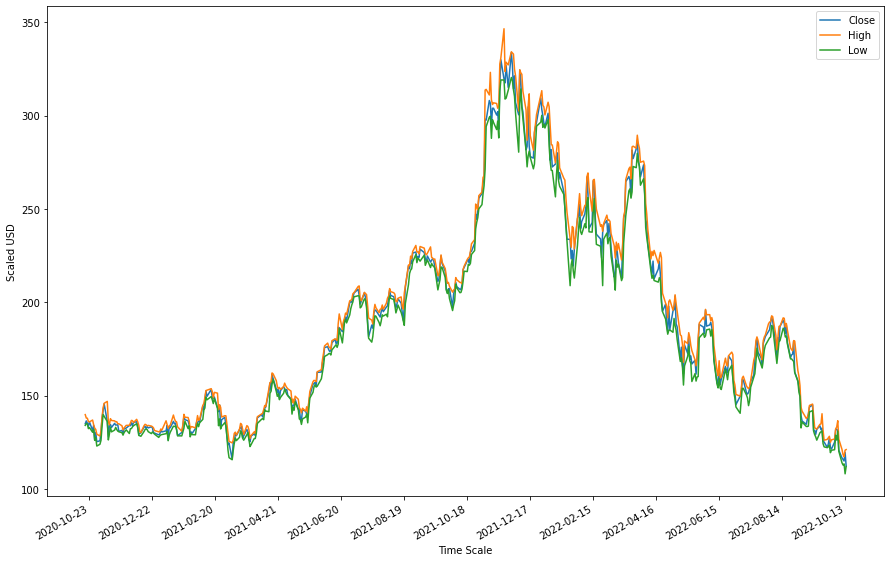

In [7]:
# Plotting the close, highs and lows points of NVDA over 2 years
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

plt.figure(figsize = (15, 10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 60))
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_data.index.values]

plt.plot(x_dates, stock_data['Close'], label = 'Close')
plt.plot(x_dates, stock_data['High'], label = 'High')
plt.plot(x_dates, stock_data['Low'], label = 'Low')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

**Data Preprocessing**

In [49]:
target_y = stock_data['Close']
x_feat = stock_data.iloc[:,0:3]
training_data_len = math.ceil(len(target_y.values * 0.8))

# Usage of standard scaler to rescale values between -1 and 1
# This is to rescale the data within a fixed range to avoid messing the model
# up with large numeric data
 
sc = StandardScaler()
x_ft = sc.fit_transform(x_feat.values)
x_ft = pd.DataFrame(columns = x_feat.columns,
                    data = x_ft,
                    index = x_feat.index)

**Data Splitting**

In [9]:
# The function takes the entire data and creates windows of size n_steps starting
# from the beginning
def lstm_split(data, n_steps):
    x, y = [], []
    for i in range(len(data) - n_steps + 1):
        x.append(data[i:i + n_steps, :-1])
        y.append(data[i + n_steps - 1, -1]) 
    return np.array(x), np.array(y)

In [45]:
#Splitting of data into training and testing (0.8 training, 0.2 testing)
n_steps = 10
x1, y1 = lstm_split(x_ft.values, n_steps = n_steps)

train_split = 0.8
split_idx = int(np.ceil(len(x1) * train_split))
date_index = x_ft.index

x_train, x_test = x1[:split_idx], x1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
x_train_date, x_test_date = date_index[:split_idx], date_index[split_idx:]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(395, 10, 2) (395,) (98, 10, 2) (98,)


**Building The Model**

In [11]:
lstm = Sequential()
lstm.add(LSTM(50, input_shape = (x_train.shape[1], x_train.shape[2]),
              activation = 'relu', return_sequences = True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(50, return_sequences = True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(50, return_sequences = True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(50))
lstm.add(Dropout(0.2))

lstm.add(Dense(1))
lstm.compile(loss = 'mean_squared_error', optimizer = 'adam')
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [61]:
# Training
history = lstm.fit(x_train, y_train,
                   epochs = 200, batch_size = 4,
                   verbose = 2, shuffle = False)

Epoch 1/200
99/99 - 2s - loss: 0.0173 - 2s/epoch - 23ms/step
Epoch 2/200
99/99 - 2s - loss: 0.0165 - 2s/epoch - 20ms/step
Epoch 3/200
99/99 - 2s - loss: 0.0205 - 2s/epoch - 19ms/step
Epoch 4/200
99/99 - 2s - loss: 0.0172 - 2s/epoch - 19ms/step
Epoch 5/200
99/99 - 2s - loss: 0.0145 - 2s/epoch - 19ms/step
Epoch 6/200
99/99 - 2s - loss: 0.0193 - 2s/epoch - 19ms/step
Epoch 7/200
99/99 - 2s - loss: 0.0165 - 2s/epoch - 19ms/step
Epoch 8/200
99/99 - 2s - loss: 0.0174 - 2s/epoch - 20ms/step
Epoch 9/200
99/99 - 2s - loss: 0.0147 - 2s/epoch - 19ms/step
Epoch 10/200
99/99 - 2s - loss: 0.0218 - 2s/epoch - 20ms/step
Epoch 11/200
99/99 - 2s - loss: 0.0170 - 2s/epoch - 19ms/step
Epoch 12/200
99/99 - 2s - loss: 0.0141 - 2s/epoch - 20ms/step
Epoch 13/200
99/99 - 2s - loss: 0.0152 - 2s/epoch - 19ms/step
Epoch 14/200
99/99 - 2s - loss: 0.0161 - 2s/epoch - 19ms/step
Epoch 15/200
99/99 - 2s - loss: 0.0139 - 2s/epoch - 19ms/step
Epoch 16/200
99/99 - 2s - loss: 0.0161 - 2s/epoch - 20ms/step
Epoch 17/200
99/9

**Performance Evaluation**

In [62]:
# Using RMSE and MAPE 
y_pred = lstm.predict(x_test)
rmse = mean_squared_error(y_test, y_pred, squared = False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("RMSE: ", rmse)
print("MAPE: ", mape)

4/4 [==============================] - 0s 8ms/step
RMSE:  0.08891352118377394
MAPE:  0.3685860855243757


**Data Visualization of Predictions**

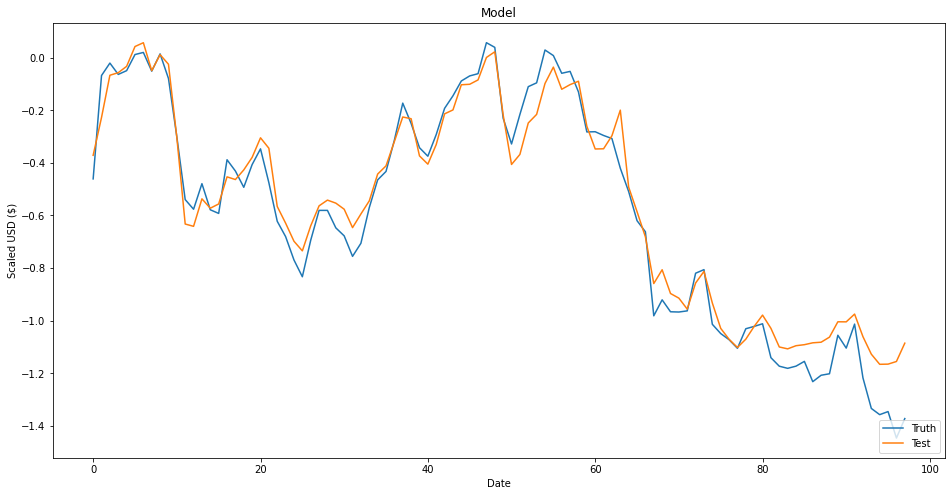

In [63]:
truth = y_test
test = y_pred

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Scaled USD ($)')
plt.plot(truth)
plt.plot(test)
plt.legend(['Truth', 'Test'], loc='lower right')
plt.show()